# Linear Regression Model

This is the first project of our data science fundamentals. This project is designed to solidify your understanding of the concepts we have learned in Regression and to test your knowledge on regression modelling. There are four main objectives of this project.

1\. Build Linear Regression Models 
* Use closed form solution to estimate parameters
* Use packages of choice to estimate parameters<br>

2\. Model Performance Assessment
* Provide an analytical rationale with choice of model
* Visualize the Model performance
  * MSE, R-Squared, Train and Test Error <br>

3\. Model Interpretation

* Intepret the results of your model
* Intepret the model assement <br>
    
4\. Model Dianostics
* Does the model meet the regression assumptions
    
#### About this Notebook

1\. This notebook should guide you through this project and provide started code
2\. The dataset used is the housing dataset from Seattle homes
3\. Feel free to consult online resources when stuck or discuss with data science team members


Let's get started.

### Packages

Importing the necessary packages for the analysis

In [2]:
# Necessary Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Model and data preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.feature_selection import RFE

%matplotlib inline


Now that you have imported your packages, let's read the data that we are going to be using. The dataset provided is a titled *housing_data.csv* and contains housing prices and information about the features of the houses. Below, read the data into a variable and visualize the top 8 rows of the data.  

In [3]:
# Initiliazing seed
np.random.seed(42)

data = pd.read_csv('housing_data.csv')
# data = pd.read_csv('housing_data_2.csv')
data.head(8)


,lot_area,firstfloor_sqft,living_area,bath,garage_area,price
0,8450,856,1710,2,548,208500
1,9600,1262,1262,2,460,181500
2,11250,920,1786,2,608,223500
3,9550,961,1717,1,642,140000
4,14260,1145,2198,2,836,250000
5,14115,796,1362,1,480,143000
6,10084,1694,1694,2,636,307000
7,10382,1107,2090,2,484,200000


### Split data into train and test

In the code below, we need to split the data into the train and test for modeling and validation of our models. We will cover the Train/Validation/Test as we go along in the project. Fill the following code.

1\. Subset the features to the variable: features <br>
2\. Subset the target variable: target <br>
3\. Set the test size in proportion in to a variable: test_size <br>


In [7]:
features = data.drop('price', axis=1)
target = data['price'].values
test_size = .33


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size, random_state=1)

### Data Visualization

The best way to explore the data we have is to build some plots that can help us determine the relationship of the data. We can use a scatter matrix to explore all our variables. Below is some starter code to build the scatter matrix 

#### Correlation Matrix

In the code below, compute the correlation matrix and write a few thoughts about the observations. In doing so, consider the interplay in the features and how their correlation may affect your modeling.

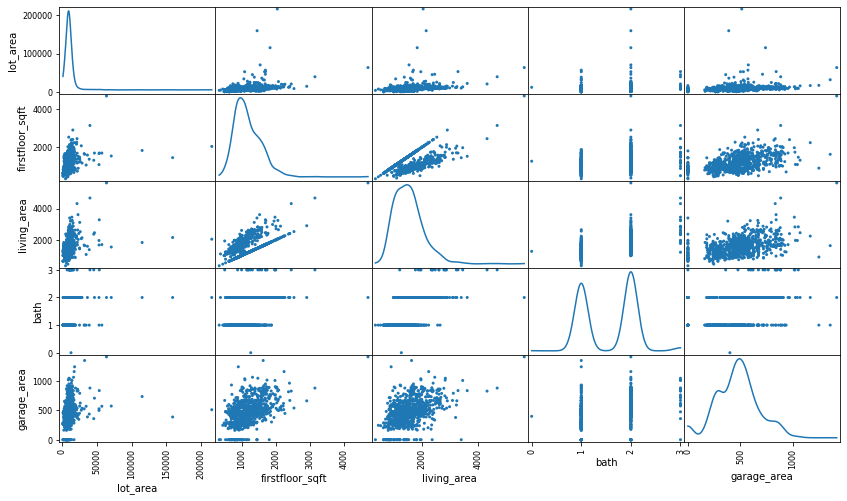

In [10]:
corr_matrix = pd.plotting.scatter_matrix(X_train, figsize=(14,8), alpha=1, diagonal='kde')

Based on the scatter matrix above, write a brief description of what you observe. In thinking about the description, think about the relationship and whether linear regression is an appropriate choice for modelling this data.

#### a. lot_area 
My initial intutions tell me that lot_area would be the best indicator of price; that being said, there is a weak correlation between lot_area and the other features, which is a good sign! However, the distribution is dramatically skewed-right indicating that the mean lot_area is greater than the median. This tells me that lot_area stays around the same size while price increases. In turn, that tells me that some other feature is helping determine the price bceause if lot_area we're determining the increase in price, we'd see a linear distribution. In determining the best feature for my linear regression model, I think lot_area may be one of the least fitting to use.

#### b. firstfloor_sqft
There is a stronger correlation between firstfloor_sqft and the other features. The distrubution is still skewed-right making the median a better measure of center. firstfloor_sqft would be a good candidate for the linear regression model becuse of the stronger correlation and wider distribution; however, there appears to be a overly strong, linear correlation between firstfloor_sqft and living_area. Given that this linear correlation goes against the Regression Assumption that "all inputs are linearly independent," I would not consider using both in my model. I could, however, use one or the other. 

#### c. living_area
There is a similarly strong correlation between living_area (as compared to firstfloor_sqft) and the other features, but these plots are better distributed than firstfloor_sqft. A right skew still exists, but less so than the firstfloor_sqft. However, the observation of a strong, linear correlation between firstfloor_sqft and living_area (or living_area and firstfloor_sqft) is reinforced here. Thus, I would not use both of these in my final model and having to choose between the two, I will likely choose living_area since it appears to be more well-distributed. 

#### d. bath
Baths are static numbers, so the plots are much less distributed; however, the length and the clustering of the bath to living_area & bath to garage_area may indicate a correlation. Since I cannot use both living_area and firstfloor_sqft, and I think living_area has a better distribution, I would consider using bath in conjunction with living_area. 

#### e. garage_area 
Garage_area appears to be well-distributed with the lowest correlation between the other features. This could make it a great fit for the final regression model. It's also the least skewed right distribution. 

#### Correlation Matrix

In the code below, compute the correlation matrix and write a few thoughts about the observations. In doing so, consider the interplay in the features and how their correlation may affect your modeling.
 
The correlation matrix below is in-line with my thought process. Lot_area has the lowest correlation between it and the other features, but it's not well distributed. firstfloor_sqft has a strong correlation between it and living_area. Given that the correlation is just over 0.5, both features may be able to be used in the model given that the correlation isn't overly strong; however, to be most accurate, I plan to leave out one of them (likely firstfloor_sqft). living_area also reflects this strong correlation between it and firstfloor_sqft. Surprisingly, there is a strong correlation between living_area and bath. Looking solely at the scatter matrix, I did not see this strong correlation. This changes my approach slighlty, which I will outline below. garage_area, again, has the lowest correlations while being the most well-distributed.

In [11]:
# Use pandas correlation function
x_train.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,lot_area,firstfloor_sqft,living_area,bath,garage_area
lot_area,1.0,0.31,0.28,0.13,0.18
firstfloor_sqft,0.31,1.0,0.58,0.39,0.5
living_area,0.28,0.58,1.0,0.62,0.48
bath,0.13,0.39,0.62,1.0,0.43
garage_area,0.18,0.5,0.48,0.43,1.0


#### Approach 
Given this new correlation information, I will approach the regression model in one of the following ways:
        1. Leave out bath as a feature and use living_area
        2. Use firstfloor_sqft instead of living_area

## 1. Build the Model

Now that we have explored the data at a high level, let's build our model. From our sessions, we have discussed both closed form solution, gradient descent and using packages. In this section you will create your own estimators. Starter code is provided to makes this easier.


#### 1.1. Closed Form Solution
Recall: <br>
$$\beta_0 = \bar {y} - \beta_1 \bar{x}$$ <br>
$$\beta_1 = \frac {cov(x, y)} {var(x)}$$ <br>

Below, let's define functions that will compute these parameters

In [12]:
# Pass the necessary arguments in the function to calculate the coefficients

def compute_estimators(feature, target):
    n1 = np.sum(feature*target) - np.mean(target)*np.sum(feature)
    d1 = np.sum(feature*feature) - np.mean(feature)*np.sum(feature)
    
    # Compute the Intercept and Slope
    beta1 = n1/d1
    beta0 = np.mean(target) - beta1*np.mean(feature)
    
    return beta0, beta1 # Return the Intercept and Slope


Run the compute estimators function above and display the estimated coefficients for any of the predictors/input variables.

In [19]:
#### Computing coefficients for our model by hand using the actual mathematical equations
beta0, beta1 = compute_estimators(X_train['living_area'], y_train)
print("beta0: ", beta0)
print("beta1: ", beta1)

beta0:  29454.3663995151
beta1:  99.75522408843003


#### 1.2. sklearn solution

Now that we know how to compute the estimators, let's leverage the sklearn module to compute the metrics for us. We have already imported the linear model, let's initialize the model and compute the coefficients for the model with the input above.

In [22]:
# Initilize the linear Regression model here
model = linear_model.LinearRegression()

# Pass in the correct inputs
model.fit(X_train[['living_area']], y_train)

# Print the coefficients
print("beta0:", model.intercept_)
print("beta1:", model.coef_) 
#### Computing coefficients for our model using the sklearn package 


beta0: 29454.366399514984
beta1: [99.75522409]


Do the results from the cell above and your implementation match? They should be very close to each other.
#### Yes!! They match!  

### 2. Model Evaluation

Now that we have estimated our single model. We are going to compute the coefficients for all the inputs. We can use a for loop for multiple model estimation. However, we need to create a few functions:

1\. Prediction function: Functions to compute the predictions <br>
2\. MSE: Function to compute Mean Square Error <br>

In [25]:
#Function that computes predictions of our model using the betas above + the feature data we've been using 
def model_predictions(intercept, slope, feature):
    """ Compute Model Predictions """
    y_hat = intercept+(slope*feature)
    
    return y_hat

y_hat = model_predictions(beta0, beta1, x_train['living_area'])

#Function to compute MSE which determines the total loss for each predicted data point in our model
def mean_square_error(y_outcome, predictions):
    """ Compute the mean square error """
    mse = (np.sum((y_outcome - predictions) ** 2))/np.size(predictions)
    
    return mse

mse = mean_square_error(y_train, y_hat)
print(mse)

3105439255.088016


The last function we need is a plotting function to visualize our predictions relative to our data.


## Considerations/Reasoning

#### Inital Feature Analysis - "Best" Feature (a priori)
Living area is the best metric to use to train the linear model because it incorporates multiple of the other features within it: first floor living space & bath. Living area has a high correlation with both first floor sq ft (0.53) and baths (0.63). Based on the other correlations, these are the two highest, and thus should immediately be eliminated. Additionally, based on initial intuition, one would assume that an increase in the metric "firstfloor sqft" will lead to an increase in the "living area" metric; if both firstfloor sqft and overall living area are increased, the "bath" metric will likely also increase to accommodate the additional living area/sqft in a home. Thus, I will not need to use them in my model because these can be accurately represented by the feature "living area."


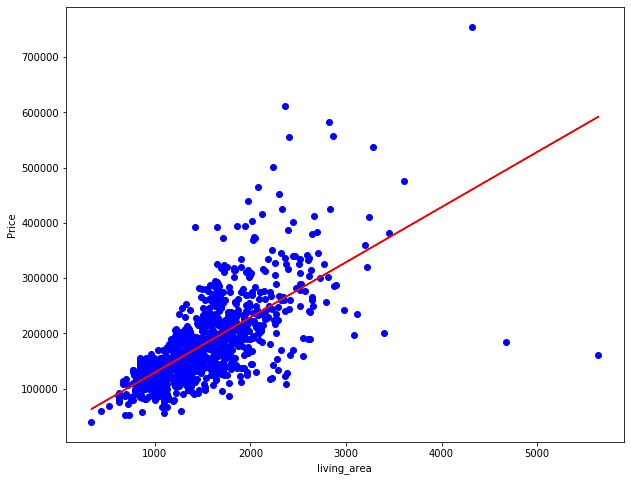

In [26]:
#Function used to plot the data
def plotting_model(feature, target, predictions, name):
    """ Create a scatter and predictions  """
    fig = plt.figure(figsize=(10,8)) 
    plot_model = model.fit(feature, target)
    plt.scatter(x=feature, y=target, color='blue')
    plt.plot(feature, predictions, color='red')
    plt.xlabel(name)
    plt.ylabel('Price')

    return model

model = plotting_model(X_train[['living_area']], y_train, y_hat, data['living_area'].name)


### Single Feature Assessment

living_area
beta0: 18569.02585648722
beta1: 107.13035896582521
mean squared error: 3139843209.6665273

garage_area
beta0: 71357.42140747681
beta1: 231.64561450940457
mean squared error: 3855549505.982716

lot_area
beta0: 158836.1518968766
beta1: 2.0999719517076745
mean squared error: 5867752122.509075

firstfloor_sqft
beta0: 36173.44679512104
beta1: 124.5006222206584
mean squared error: 3991838509.3767366

bath
beta0: 54388.27732380542
beta1: 80848.16678654008
mean squared error: 4324288349.648311



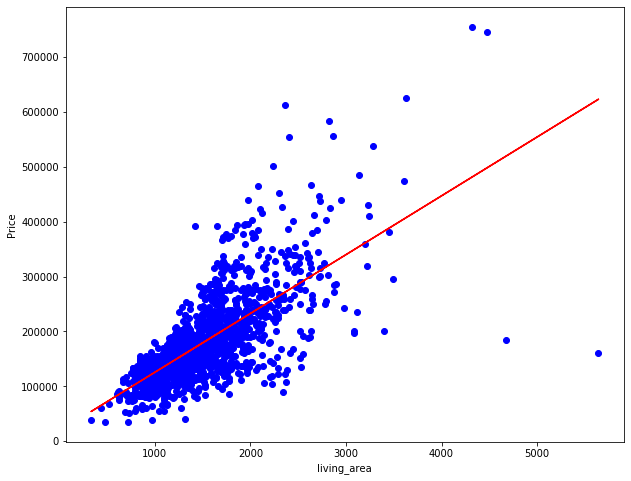

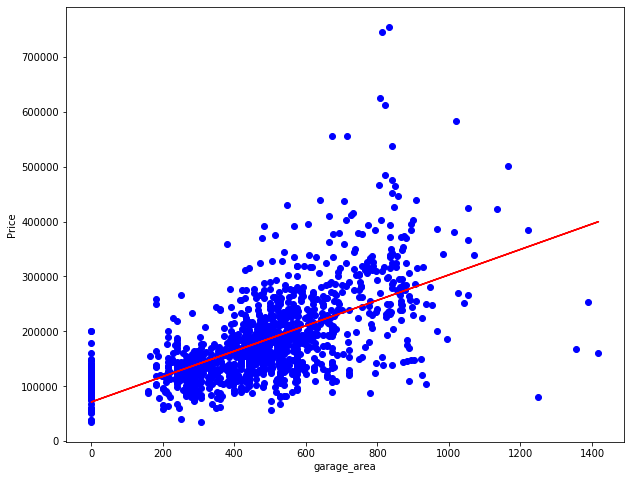

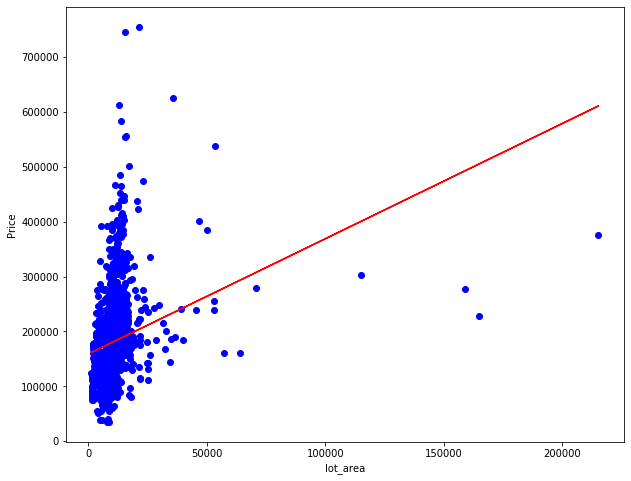

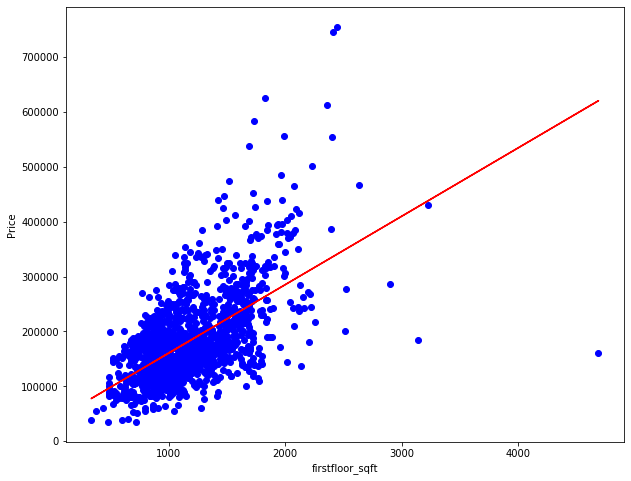

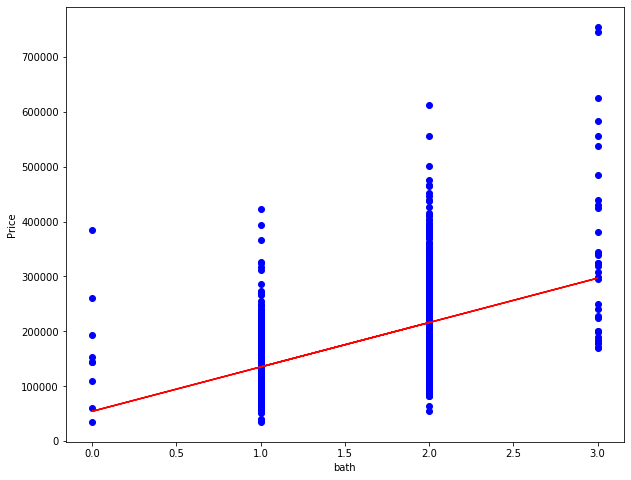

In [27]:
#Running each feature through to determine which has best linear fit
features = data[['living_area', 'garage_area', 'lot_area', 'firstfloor_sqft', 'bath']]
count = 0

for feature in features:
    feature = features.iloc[:, count]
    # Compute the Coefficients
    beta0, beta1 = compute_estimators(feature, target)
    count+=1

    # Compute the Train and Test Predictions
    y_hat = model_predictions(beta0, beta1, feature)
    
    # Compute the MSE
    mse = mean_square_error(target, y_hat)
    
    
        # Print the Intercept and Slope
    print(feature.name)
    print('beta0:', beta0)
    print('beta1:', beta1)
    print('mean squared error:', mse)
    print()
    
    # Plot the Model Scatter  
    name = feature.name
    model = plotting_model(feature.values.reshape(-1, 1), target, y_hat, name)

#### Analysis of Feature Linear Models

Living Area has the lowest MSE 2815789647.7664313 of all the individual models, and the best linear fit.

Garage Area is the next lowest MSE 3466639234.8407283, and the model is mostly linear; however, the bottom left of the model is concerning. You'll notice that a large number of data points go vertically upward indicating an increase in price with 0 garage area. That says to me that garage area isn't predicting the price of these homes, which indicates that it isn't a good feature to use.

#### Run Model Assessment

Now that we have our functions ready, we can build individual models, compute preductions, plot our model results and determine our MSE. Notice that we compute our MSE on the test set and not the train set



living_area
beta0: 13483.181531433365
beta1: 112.1178116977946
mean squared error: 2765179471.504568



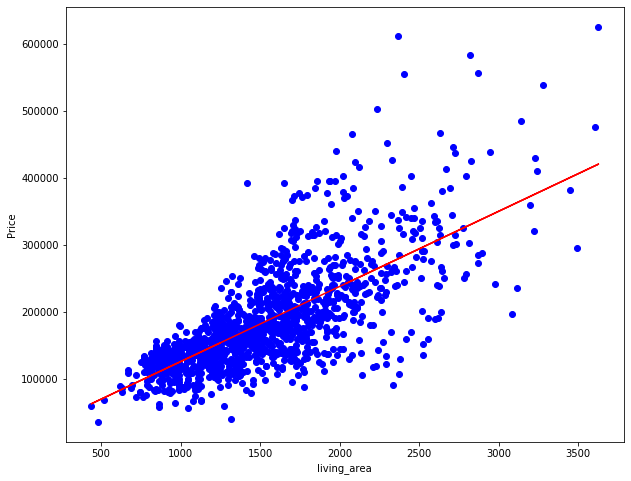

In [31]:
#Modeling Living Area
x = data['living_area']

beta0, beta1 = compute_estimators(x, target)
print('living_area')
print('beta0:', beta0)
print('beta1:', beta1)

y_hat = model_predictions(beta0, beta1, x)
name = 'living_area'

model = plotting_model(x.values.reshape(-1, 1), target, y_hat, name)

mse = mean_square_error(target, y_hat)
print('mean squared error:', mse)
print()

### 3. Model Interpretation

Now that you have calculated all the individual models in the dataset, provide an analytics rationale for which model has performed best. To provide some additional assessment metrics, let's create a function to compute the R-Squared.

#### Mathematically:

$$R^2 = \frac {SS_{Regression}}{SS_{Total}} = 1 - \frac {SS_{Error}}{SS_{Total}}$$<br>

where:<br>
$SS_{Regression} = \sum (\widehat {y_i} - \bar {y_i})^2$<br>
$SS_{Total} = \sum ({y_i} - \bar {y_i})^2$<br>
$SS_{Error} = \sum ({y_i} - \widehat {y_i})^2$




In [32]:
#ssr = sum of squares of regression --> variance of prediction from the mean
#sst = sum of squares total --> variance of the actuals from the prediction
#sse = sume of squares error --> variance of the atuals from the mean
def r_squared(y_outcome, predictions):
    """ Compute the R Squared """
    ssr = np.sum((predictions - np.mean(y_outcome))**2)
    sst = np.sum((y_outcome - np.mean(y_outcome))**2)
    sse = np.sum((y_outcome - predictions)**2)
    
#    print(sse, "/", sst)
    print("1 - SSE/SST =", round((1 - (sse/sst))*100), "%")
    
    rss = (ssr/sst) * 100
    
    return rss

Now that you we have R Squared calculated, evaluate the R Squared for the test group across all models and determine what model explains the data best. 

In [33]:
rss = r_squared(target, y_hat)
print("R-Squared =", round(rss), "%")
count += 1

1 - SSE/SST = 52.0 %
R-Squared = 52.0 %


### R-Squared Adjusted

$R^2-adjusted = 1 - \frac {(1-R^2)(n-1)}{n-k-1}$

In [34]:
def r_squared_adjusted(rss, sample_size, regressors):
    n = np.size(sample_size)
    k = regressors
    numerator = (1-rss)*(n)
    denominator = n-k-1
    rssAdj = 1 - (numerator / denominator)
    
    return rssAdj

rssAdj = r_squared_adjusted(rss, y_hat, 2)

In [35]:
print(round(rssAdj), "%")

52.0 %


### 4. Model Diagnostics

Linear regressions depends on meetings assumption in the model. While we have not yet talked about the assumptions, you goal is to research and develop an intuitive understanding of why the assumptions make sense. We will walk through this portion on Multiple Linear Regression Project